In [8]:
import osmnx as ox
import json
import math

In [9]:

#Cuidad
#lugar = "Montevideo, Uruguay"
#lugar = "Ciudad de buenos aires, Argentina"
#lugar = "Sao paulo, Brazil"
lugar = "Miami, USA"


#Nombre del archivo a generar
#archivo_generado = "./datos/montevideo_suburbio.json"
#archivo_generado = "./datos/CABA_suburbio.json"
#archivo_generado = "./datos/Sao Paulo_suburbio.json"
archivo_generado = "./datos/miami_suburbio.json"

#Admin level
#Depende del pais el nivel que se debe elegir, se debe mirar pais por pais en https://nominatim.openstreetmap.org/ui/search.html
admin_level = '9'

### Visualización del mapa y descarga del mapa de la ciudad

/home/dpadron/Documentos/hpc/env/lib/python3.11/site-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


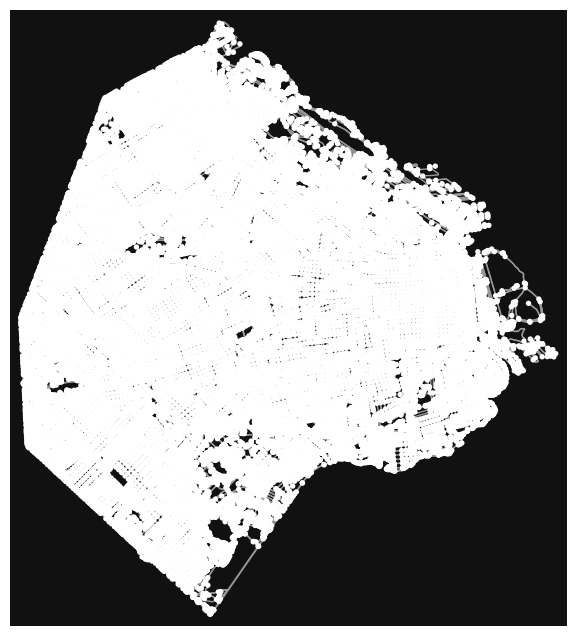

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:

place_lugar = ox.graph_from_place(lugar)
ox.plot_graph(place_lugar)

### Descarga

Descarga de los suburbios, procesamiento y los sub mapas donde sí se obtenga.

In [11]:
data_sububs = ox.features_from_place(lugar, {'place': 'suburb', 'admin_level': admin_level})

# No obtenemos informacion, parece que aun esta en contruccion para montevideo....
#data_neighbourhood = ox.features_from_place("Montevideo, Uruguay", tags={'place': 'neighbourhood'})

localizaciones_por_clave = {}
puntos_con_region = {}


for clave, nombre in data_sububs.name.items():    
    localizaciones_por_clave[clave[1]] = nombre

barios_por_punto = {}
nodos_ya_encontrados = {}

for clave, dato in data_sububs.geometry.items():
    tipo = clave[0]
    id = clave[1]
    if tipo == 'node': #Es un punto
        barios_por_punto[clave[1]] = {'lat': dato.y, 'log': dato.x}
    elif tipo == 'relation':
        g_parks = ox.graph_from_polygon(dato)
        for u, v, key, data in g_parks.edges(keys=True, data=True):
            repetido = False
            if u in nodos_ya_encontrados and  nodos_ya_encontrados[u] != id:
                repetido = True
            if v in nodos_ya_encontrados and  nodos_ya_encontrados[v] != id:
                repetido = True

            if not repetido:
                nodos_ya_encontrados[u] = id
                nodos_ya_encontrados[v] = id

/home/dpadron/Documentos/hpc/env/lib/python3.11/site-packages/osmnx/features.py:294: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


In [12]:
def zona_que_pertenece(id, lat, log):
    if id in nodos_ya_encontrados:
        return nodos_ya_encontrados[id]
    else:
        # Asignado por el punto más cercano. Muchos de los suburbios en Montevideo se encuentran únicamente definidos por un punto. 
        distancias = [(index, ox.distance.great_circle(lat, log, pos['lat'], pos['log'])) for index, pos in barios_por_punto.items()]
        bario_distancia_minima = min(distancias, key= lambda d: d[1])
        return bario_distancia_minima[0]

barrios_info = []
for clave, nombre_zona in localizaciones_por_clave.items():
    if type(nombre_zona) == str:
        barrio = {
            "id": clave, 
            "name": nombre_zona,
        }
        barrios_info.append(barrio)


nodos_info = []
for u,data in place_lugar.nodes(data=True):
    nodo = {
        "id": u,
        "x": data["x"],
        "y": data["y"],
        "suburb_id": zona_que_pertenece(u, data["y"], data["x"])
    }
    nodos_info.append(nodo)


aristas_info = []
# Iterar sobre las aristas y mostrar algunos atributos
for u, v, key, data in place_lugar.edges(keys=True, data=True):
    lanes  = data["lanes"] if "lanes" in data else 1
    rev  = data["reversed"] if "reversed" in data else 1
    maxspeed  = data["maxspeed"] if "maxspeed" in data else 0
    name = data["name"] if "name" in data else ""
    arista = {
        "source": u,
        "target": v,
        "oneway": data["oneway"],
        "length": data["length"],
        "maxspeed": maxspeed,
        "lanes": lanes,
        "reversed": rev,
        "name": name
    }
    aristas_info.append(arista)

estructura_general = {
    "suburb": barrios_info,
    "nodes": nodos_info,
    "links": aristas_info
}



with open(archivo_generado, "w", encoding='utf-8') as f:
    json.dump(estructura_general, f, ensure_ascii=False,indent=4)